In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('../SelectionFunctionToolkit')

# Get counts

In [45]:
from SelectionFunctionGaiaArchive import GaiaArchiveQuery

mag_res=0.1; col_res=1.; pos_level=7

version="gaiaedr3"; mag_res=mag_res; col_res=col_res; pos_level=pos_level
query = GaiaArchiveQuery(magnitude_column = 'phot_g_mean_mag',
                         magnitude_resolution = mag_res,
                         colour_column = 'bp_rp',
                         colour_resolution = col_res,
                         position_column='source_id',
                         position_resolution=pos_level,
                         gaia_version=version,
                         superset_criteria = ['phot_g_mean_mag is not NULL'],
                         subset_criteria=['astrometric_params_solved>3'])

In [46]:
print(query.query)

select magnitude, colour, position, count(*) as n, sum(selection) as k 
 from ( select  to_integer(floor(phot_g_mean_mag * 10)) as magnitude, 
to_integer(floor(bp_rp * 1)) as colour, 
gaia_healpix_index(7, source_id) as position, 
to_integer(IF_THEN_ELSE(astrometric_params_solved>3, 1.0, 0.0)) as selection from gaiaedr3.gaia_source 
 where phot_g_mean_mag is not NULL  ) as subquery 
 group by magnitude, colour, position


In [47]:
%time query.run_query()

Running query


OSError: [Errno 113] No route to host

In [ ]:
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts.h', 'w') as hf:
    for key in ['magnitude', 'colour', 'position', 'k', 'n']:
        hf.create_dataset(key, data=np.array(query.results[key]))
    
    hf.create_dataset('magnitude_res', data=np.array([mag_res]))
    hf.create_dataset('colour_res', data=np.array([col_res]))
    hf.create_dataset('position_level', data=np.array([pos_level]))
    hf.attrs["query"] = query.query

### Check selection function

In [4]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

In [7]:
%config Completer.use_jedi = False

## Load in selection function

In [10]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

In [11]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [9]:
M = 85; C = 1; nside=64; jmax=5; B=3.; lengthscale = 0.3
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_results.h5"

ast_sf = chisel(map_fname=map_fname, nside=8, C=C, M=M, basis_options=basis_options,
                lengthscale_m=lengthscale, lengthscale_c=lengthscale,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Mag bins: [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]
lengthscales m:1.5000000000000053 , c:0.0015


OSError: Unable to open file (unable to open file: name = '/data/asfe2/Projects/astrometry/StanOutput/chisquare_jmax5_nside64_M85_C1_l0.3_B3.0_scipy_results.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
M = 85; C = 1; nside=64; jmax=5; B=3.; lengthscale = 0.3
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}_ncores50_lbfgsb"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_latest.h5"

ast_sf = chisel(map_fname=map_fname, nside=8, C=C, M=M, basis_options=basis_options,
                lengthscale_m=lengthscale, lengthscale_c=lengthscale,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

## Load in Data

In [51]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [44]:
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=3)
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=3)
    M_bins = hf['magbins'][...]
M_bins = np.linspace(M_bins[0], M_bins[-1], M+1)
print("Mag bins:", M_bins)

box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])

Mag bins: [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.]


$$ P( k | n, p ) = \mathrm{Binomial}( k ; n, p) $$

$$ P( p | k, n ) = \frac{\mathrm{Binomial}( k ; n, p) \, \mathrm{Beta}(p | \alpha, \beta)}{\int \mathrm{d}p\, \mathrm{Binomial}( k ; n, p) \,\mathrm{Beta}(p | \alpha, \beta)} \\
= \mathrm{Beta}(p | \alpha+k, \beta+n-k)$$

$$ \mathbb{E}[p] = (\alpha + k)/(\alpha + \beta + n) $$

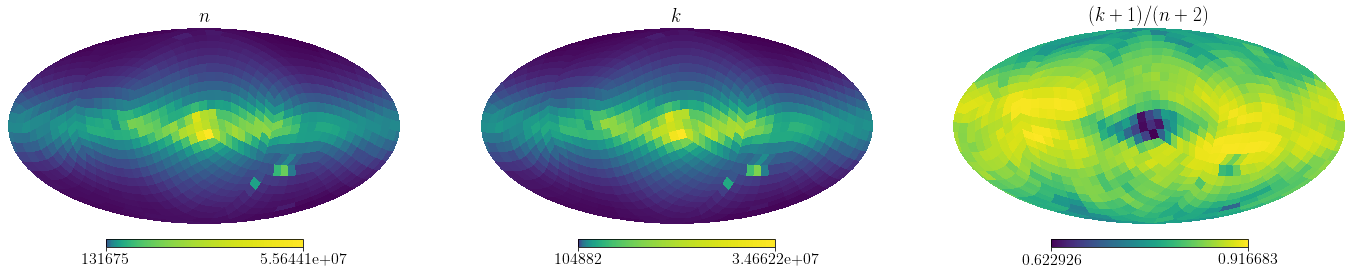

In [45]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(np.sum(box['n'], axis=(0,1))), np.max(np.sum(box['n'], axis=(0,1)))

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['k'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

## Evaluate Selection Function

$$ x = \sum_{l=0}^{l_\mathrm{max}} \, \sum_{m=-l}^{l} a_{lm} \,Y_{lm} $$

$$ p = \mathrm{expit}(x) $$

In [106]:
g = [16.51,18.51,20.51]
prob_selection = np.zeros((3,hp.nside2npix(64)))
for i in range(3):
    ra, dec = hp.pix2ang(64,np.arange(hp.nside2npix(64)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=1000)

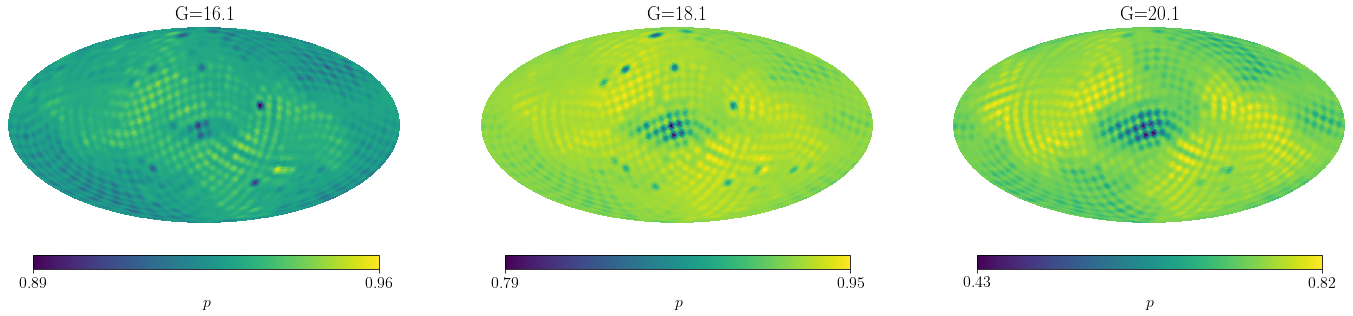

In [65]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=True, min=minmax[0], max=minmax[1], cbar=False, notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$p$', fontsize=16)
    
#plt.savefig('figs/%s_p_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

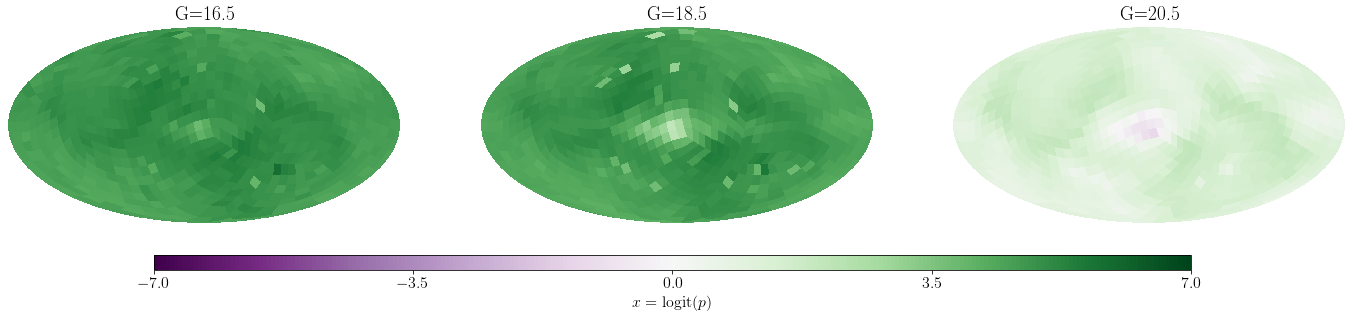

In [107]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    hp.mollview(logit(prob_selection[i]), nest=True, min=minmax[0],max=minmax[1], notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[0]/2, 0., minmax[1]/2, minmax[1]])
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=16)

#plt.savefig('figs/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Beta distribution tests of Comparison

In [67]:
g = [16.51,18.51,20.51]

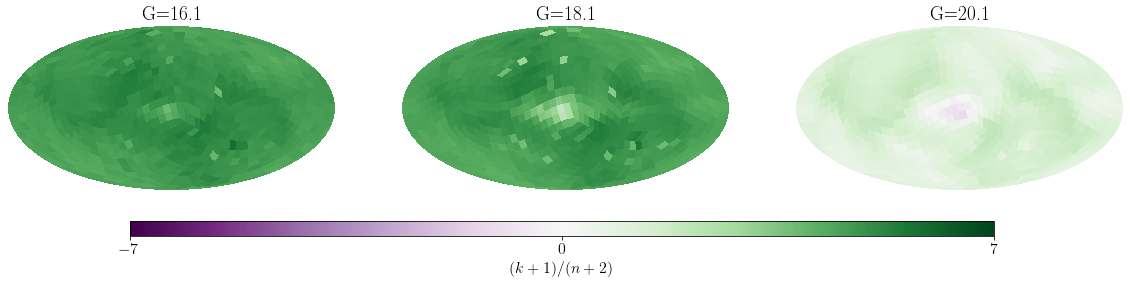

In [26]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    expected = (box['k'][g_idx,0]+1)/(box['n'][g_idx,0]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=16)

#plt.savefig('figs/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

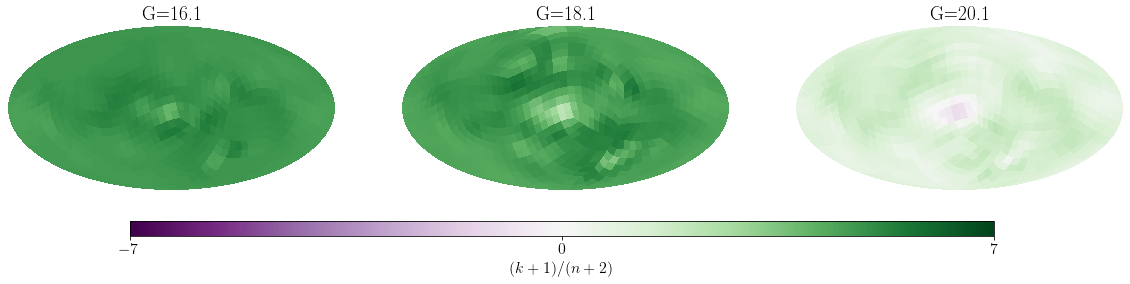

In [68]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    hp.mollview(sf_box['x'][g_idx,0], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=16)

# Load in full pixel selection function

In [125]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]

## P-value of k

$$ p_\mathrm{value} \sim U[I_{k-1}, I_k]$$

$$ I_k = \sum_{j=0}^{k} \mathrm{Binomial}(\,j\,;\, n,\,p) $$

In [126]:
g = [16.1,18.5,20.9]

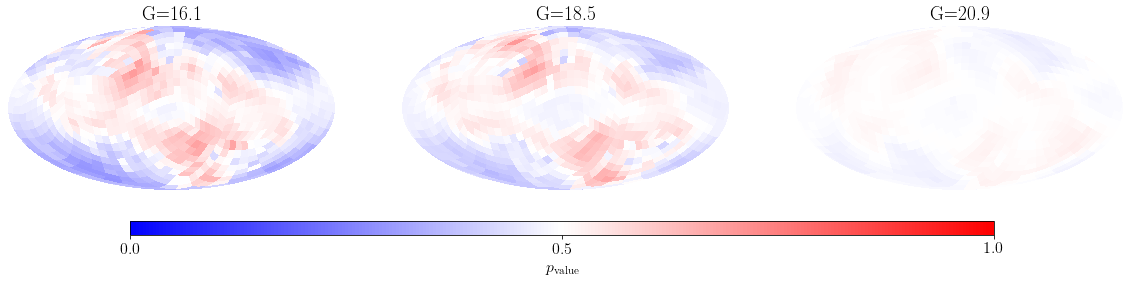

In [127]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$p_\mathrm{value}$', fontsize=16)

#plt.savefig('figs/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

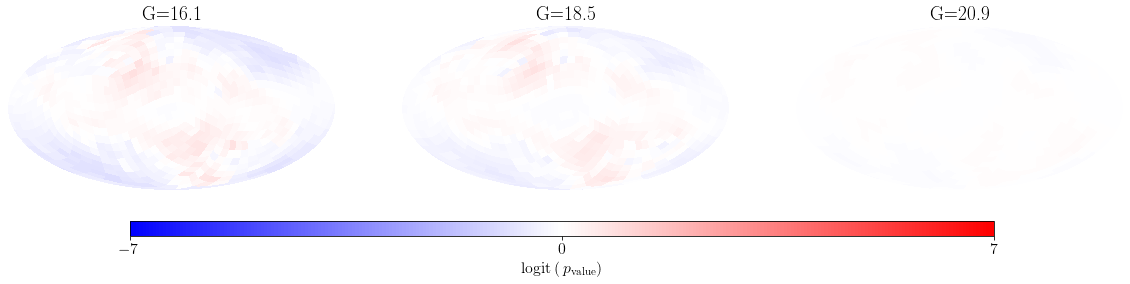

In [128]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,p_\mathrm{value}\right)$', fontsize=16)

#plt.savefig('figs/%s_logit-binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

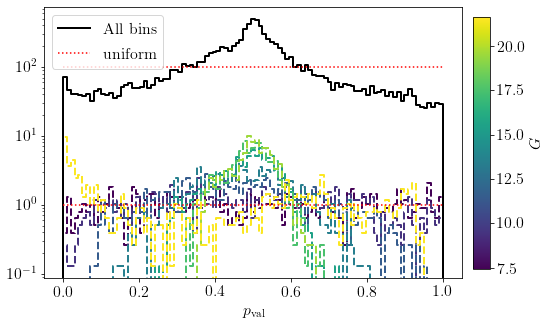

In [129]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/100)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [100,100], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

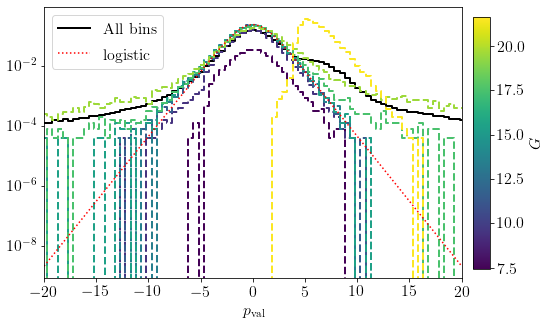

In [35]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

# Magnitude distribution

In [162]:
ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)

g = np.linspace(5,22,500)

rr, gg = np.meshgrid(ra, g)
dd, gg = np.meshgrid(dec, g)

prob_selection = np.zeros((len(ra), g.shape[0]))
coords = Source(rr*units.deg, dd*units.deg, frame='icrs', photometry={'gaia_g':gg})

ast_sf._g_min = np.min(g)
ast_sf._g_max = np.max(g)
prob_selection = ast_sf(coords, chunksize=1000)

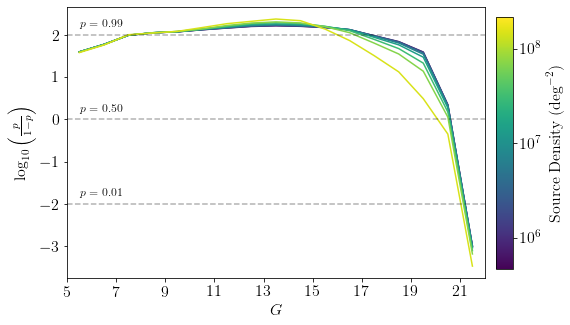

In [173]:
sd_bins = np.logspace(5 + 2./3, 8 + 1./3, 9)
source_count = np.sum(box['n'], axis=(0,1))
source_density = source_count/area

cmap=cm.viridis

fig, ax = plt.subplots(1,1,figsize=(8,5))
for i, sd in enumerate(sd_bins[:-1]):
    pix = source_density>sd_bins[i]
    
    sd = np.sqrt(sd_bins[i]*sd_bins[i+1])
    
    mean = np.sum(sf_box['x'][:,0,:].T[pix] .T* source_count[pix], axis=1) /np.sum(source_count[pix])
    plt.plot(ast_sf.Mcenters, mean / np.log(10),
            c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))
    
#     mean = np.sum(logit(prob_selection.T[pix]) * source_count[pix,None], axis=0) /np.sum(source_count[pix])
#     plt.plot(g, mean / np.log(10),
#             c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))
    
plt.xlabel(r'$G$'); plt.ylabel(r'$\mathrm{log}_{10}\left(\frac{p}{1-p}\right)$')
plt.xlim(np.min(g), np.max(g))
ax.set_xticks(np.arange(5,21.1,2.))

for p in [1e-2,0.5,1-1e-2]:
    plt.plot([np.min(g), np.max(g)], [np.log10(p/(1-p)), np.log10(p/(1-p))], '--k', alpha=0.3)
    if p>0.005: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$p = {:.2f}$'.format(p), fontsize=12)
    else: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$10^{%d}$' % np.log10(p), fontsize=12)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_bins[0], vmax=sd_bins[-1],
                   ticks=10**(np.arange(5,9)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,9)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$', fontsize=16)

#plt.savefig('figs/%s_x-vs-mag_meansd.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [244]:
# Import chisel
sys.path.append('../SelectionFunctionToolkit/')
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m, M = M, Mlim = [M_bins[0], M_bins[-1]],
                lengthscale_c = lengthscale_c, C = C, Clim = [-100, 100],
                nside = nside,
                sparse = True, pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/StanOutput/',
                stan_model_directory='../SelectionFunctionToolkit/StanModels'
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


Spherical basis file loaded
17 17
1 1
88.58% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_un
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [194]:
from numba import njit

@njit
def matrix_multiply(out, b, KM, KC, modes):
    out*=0.

    # Iterate over pixels
    for i, iS in enumerate(modes):
        out[i] += np.dot(np.dot(KM[i], b[iS]), KC[i])

mag = g
color = np.zeros(len(mag))
modes = np.zeros(len(mag), dtype=int)
        
# Contstruct covariance kernel for new positions.
KmM = ast_sf.covariance_kernel(mag, ast_sf.Mcenters, lengthscale=ast_sf.lengthscale_m)
KcC = ast_sf.covariance_kernel(color, ast_sf.Ccenters, lengthscale=ast_sf.lengthscale_c)

b_out = np.zeros(len(modes))
matrix_multiply(b_out, sf_box['b'], (KmM @ ast_sf._inv_KMM), (KcC @ ast_sf._inv_KCC), modes)

In [224]:
g = np.linspace(5.5,22,100)
col = np.zeros(len(g))

# Contstruct covariance kernel for new positions.
KmM = ast_sf.covariance_kernel(g, ast_sf.Mcenters, lengthscale=ast_sf.lengthscale_m)
KcC = ast_sf.covariance_kernel(col, ast_sf.Ccenters, lengthscale=ast_sf.lengthscale_c)

# Estimate alm using Gaussian Process
_b = np.sum ( ((KmM @ ast_sf._inv_KMM) @ ast_sf.b) * (KcC @ ast_sf._inv_KCC)[None, :,:] , axis=2)

In [228]:
from astropy.coordinates import SkyCoord

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


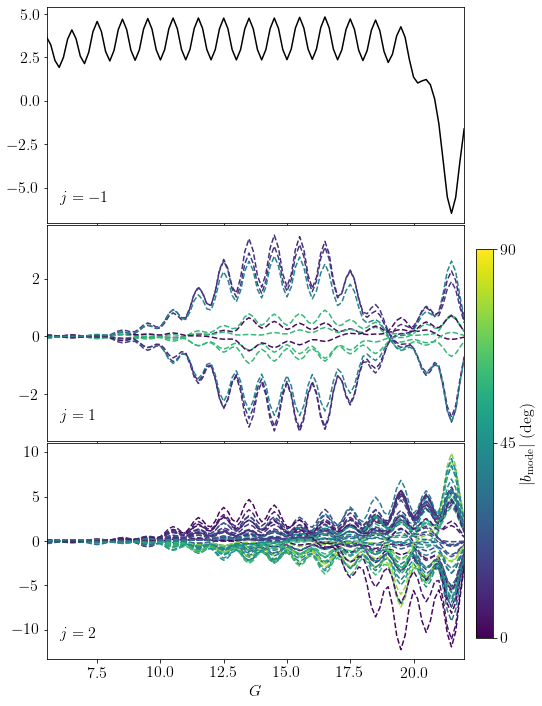

In [251]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.viridis
logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,1,2]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        plt.plot(g, _b[imode]/pychisel.sigma[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            plt.plot(g, _b[imode]/pychisel.sigma[imode], '--', color=cmap((np.abs(b[_m]))/90))
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

#plt.savefig('figs/%s_alm-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

# Progress review

In [8]:
M = 85; C = 1; nside=64; jmax=5; B=3.; lengthscale = 0.3
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_results.h5"

box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = hf['n'][...]
    box['k'] = hf['k'][...]
    M_bins = hf['magbins'][...]
    C_bins = np.array([-100,100])
print("Mag bins:", np.linspace(M_bins[0], M_bins[-1], M+1))
# Calculate lengthscales in units of bins
M_original, C_original = box['k'].shape[:2]
lengthscale_m = lengthscale/((M_bins[1]-M_bins[0])*(M_original/M))
lengthscale_c = lengthscale/((C_bins[1]-C_bins[0])*(C_original/C))
print(f"lengthscales m:{lengthscale_m} , c:{lengthscale_c}")

Mag bins: [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]
lengthscales m:1.5000000000000053 , c:0.0015


In [9]:
ncores=50
file_root = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}_ncores{ncores}mp_lbfgsb"
print(file_root)
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

# Import chisel
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                Mlim = [M_bins[0], M_bins[-1]],
                Clim = [C_bins[0], C_bins[-1]],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/PyOutput/',
                stan_model_directory='../SelectionFunctionToolkit/StanModels/'
                )

chisquare_jmax5_nside64_M85_C1_l0.3_B3.0_ncores50mp_lbfgsb
Spherical basis file loaded
85 85
1 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


84.30% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_un
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [13]:
with h5py.File('/data/asfe2/Projects/astrometry/PyOutput/chisquare_jmax5_nside64_M85_C1_l0.3_B3.0_ncores50mp_lbfgsb_latest.h', 'r') as hf:
    pychisel.optimum_z = hf[list(hf.keys())[0]][...]

In [18]:
pychisel._generate_args(sparse=True)

In [19]:
pychisel.optimum_b, pychisel.optimum_x = pychisel._get_bx(pychisel.optimum_z)

MemoryError: Unable to allocate memory to append item

In [ ]:
pychisel.file_root

In [ ]:
# Save optimum to h5py
pychisel.optimum_results_file = pychisel.file_root+'_scipy_latest.h5'
pychisel.save_h5(time.time()-tstart)